# Final projection exploration notebook

Dataset: https://www.kaggle.com/datasets/crawford/cat-dataset/data, Oct 9 2024, 11:05am

In [1]:
import os
import pandas as pd

data_dir = './cats/CAT_00'

In [2]:
class DataLoader:
    def __init__(self, data_dir: str):
        self.train, self.dev, self.test = self._read_files(data_dir)

    def _read_files(self, data_dir):
        catfiles, pointfiles = list(), list()
        for root, dirs, files in os.walk(data_dir):
            for fname in sorted(files):
                if fname.endswith('jpg'):
                    catfiles.append(os.path.join(root, fname))
                elif fname.endswith('cat'):
                    pointfiles.append(os.path.join(root, fname))

        data_df = pd.DataFrame({'cats': catfiles, 'points': pointfiles})

        # Set cutoff points.
        train_len = int(len(data_df)*0.8)
        dev_len = int(train_len + len(data_df)*0.1)

        # Split data.
        train_data = data_df[:train_len]
        dev_data = data_df[train_len:dev_len]
        test_data = data_df[dev_len:]

        return train_data, dev_data, test_data


data = DataLoader(data_dir)

# Object detection

In [3]:

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


In [7]:
data.train['cats'][0], data.train['points'][0]

('./cats/CAT_00/00000001_000.jpg', './cats/CAT_00/00000001_000.jpg.cat')

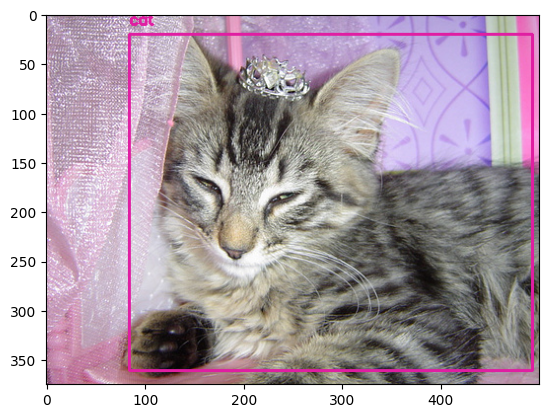

In [24]:
# Goal for object detection with bboxes
# Simplyfying assumption: No other animals than cats, 1 animal at a time
#source: https://github.com/lihini223/Object-Detection-model/blob/main/objectdetection.ipynb

img = Image.open(data.train['cats'][3])   #3 :)
img = np.array(img)

bbox, label, conf = cv.detect_common_objects(img, model='yolov3')
output_image = draw_bbox(img, bbox, label, conf)

plt.imshow(output_image)

In [ ]:
# polygon maping?

# refine to: face, body, paws, tail

In [23]:
# lit:
# https://pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/
# Faster R-CNN paper: https://arxiv.org/abs/1506.01497
# faster r-cnn in pytorch: http://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn

## PLAN

# 1: where is the cat?
# -> Object detection

# 2: what colour is it?
# -> unsupervised clusterint

# Unsupervised clustering

In [ ]:
# features: max pooling for darkest & lightest areas, also mean colour
# normalise with cnn first to reduce noise, also adjust for lighting
# later adapt if u use different region?

In [ ]:
# code example?
# https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb
